In [1]:
import osmnx as ox
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import sqlite3
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="osmnx")

In [2]:
data_parent_directory = "../../data"
data_parent_directory_maps = f"{data_parent_directory}/maps"
table_name = "vehicles"
file_name = "vehicles"

database_file_path = f"{data_parent_directory}/{file_name}.db"

In [3]:

conn = sqlite3.connect(database_file_path)
gps_data = pd.read_sql(f"SELECT * FROM {table_name}", conn)
conn.close()

gps_data = gpd.GeoDataFrame(gps_data, geometry=gpd.points_from_xy(gps_data["lon"], gps_data["lat"]))
gps_data = gps_data.drop(columns=["lon", "lat", "id"])
gps_data = gps_data.drop_duplicates()
gps_data = gps_data.set_crs(epsg=4326) # it's standard coordinate system with degrees
# calculate distances and velocities in 2180 because it's in meters, and later convert it to 3857

gps_data['time'] = pd.to_datetime(gps_data['time'], format="%Y-%m-%d %H:%M:%S", errors='coerce')
gps_data.head()

,time,line,vehicle_number,brigade,geometry
0,2025-03-09 11:20:17,119,1000,3,POINT (21.02194 52.20786)
1,2025-03-09 04:44:10,219,1001,3,POINT (21.1176 52.23413)
2,2025-03-09 11:20:03,219,1002,2,POINT (21.10244 52.22279)
3,2025-03-09 11:20:10,119,1003,1,POINT (21.20567 52.21004)
4,2025-03-09 11:20:04,196,1004,1,POINT (21.17813 52.2585)


In [27]:
gps_data_processed = gps_data.copy()
gps_data_processed = gps_data_processed.to_crs(epsg="2180")
gps_data_processed["id"] = gps_data_processed[["line", "vehicle_number", "brigade"]].astype(str).agg("|".join, axis=1)
gps_data_processed = gps_data_processed.sort_values(["id", "time"])

gps_data_processed["x"] = gps_data_processed.geometry.x
gps_data_processed["y"] = gps_data_processed.geometry.y

gps_data_processed["dx"] = gps_data_processed.groupby("id")["x"].diff()
gps_data_processed["dy"] = gps_data_processed.groupby("id")["y"].diff()
gps_data_processed["dr"] = np.hypot(gps_data_processed["dx"], gps_data_processed["dy"])

gps_data_processed["dt"] = gps_data_processed.groupby("id")["time"].diff().dt.total_seconds()

gps_data_processed["speed"] = gps_data_processed["dr"] / gps_data_processed["dt"] * 3.6

gps_data_processed = gps_data_processed.to_crs(epsg="3857")
gps_data_processed

,time,line,vehicle_number,brigade,geometry,id,x,y,dx,dy,dr,dt,speed
655,2024-11-22 10:44:27,100,4942,M1,POINT (2334248.996 6849120.992),100|4942|M1,634305.009998,491173.647358,NaN,NaN,NaN,NaN,NaN
165166,2025-03-09 11:56:15,102,1411,585,POINT (2342384.948 6844024.627),102|1411|585,639377.760238,488196.053406,NaN,NaN,NaN,NaN,NaN
167705,2025-03-09 11:56:51,102,1411,585,POINT (2342383.055 6844022.627),102|1411|585,639376.634491,488194.797760,-1.125747,-1.255646,1.686402,36.0,0.168640
170245,2025-03-09 11:57:38,102,1411,585,POINT (2342385.505 6844021.9),102|1411|585,639378.148488,488194.395379,1.513997,-0.402381,1.566556,47.0,0.119992
172785,2025-03-09 11:58:09,102,1411,585,POINT (2342383.055 6844021.9),102|1411|585,639376.647027,488194.353054,-1.501462,-0.042324,1.502058,31.0,0.174433
...,...,...,...,...,...,...,...,...,...,...,...,...,...
596476,2025-03-09 13:30:16,ZM1,9853,4,POINT (2345284.598 6823602.596),ZM1|9853|4,641512.203877,475741.959515,-1.349396,-0.706052,1.522951,28.0,0.195808
599017,2025-03-09 13:30:49,ZM1,9853,4,POINT (2345286.824 6823603.684),ZM1|9853|4,641513.553274,475742.665567,1.349396,0.706052,1.522951,33.0,0.166140
601558,2025-03-09 13:31:38,ZM1,9853,4,POINT (2345303.522 6823592.804),ZM1|9853|4,641524.006512,475736.287685,10.453238,-6.377882,12.245308,49.0,0.899655
604096,2025-03-09 13:32:22,ZM1,9853,4,POINT (2345286.824 6823602.596),ZM1|9853|4,641513.572288,475741.998522,-10.434224,5.710837,11.894818,44.0,0.973212


In [45]:
SPEED_THRESHOLD = 0.3 
DURATION_THRESHOLD  = 5 * 60 

gps_data_no_stops = gps_data_processed.copy()

gps_data_no_stops["stationary"] = (gps_data_no_stops["speed"] <= SPEED_THRESHOLD) | gps_data_no_stops["speed"].isna()

gps_data_no_stops["run"] = (
    gps_data_no_stops.groupby("id")["stationary"]
     .transform(lambda s: s.ne(s.shift(fill_value=False)).cumsum())
)

gps_data_no_stops["duration"] = gps_data_no_stops.groupby(["id", "run"])["dt"].transform("sum")

mask_stationary_threshold = gps_data_no_stops["stationary"] & (gps_data_no_stops["duration"] >= DURATION_THRESHOLD)

is_first_row = gps_data_no_stops.groupby("id").cumcount() == 0
mask_first_stationary = is_first_row & gps_data_no_stops["stationary"]

mask_stops = mask_stationary_threshold | mask_first_stationary
gps_data_no_stops = gps_data_no_stops[~mask_stops]

gps_data_no_stops = gps_data_no_stops.drop(columns=["stationary", "run", "duration"], errors="ignore")
gps_data_no_stops.head()


,time,line,vehicle_number,brigade,geometry,id,x,y,dx,dy,dr,dt,speed
223589,2025-03-09 12:08:47,102,1411,585,POINT (2342225.427 6843835.378),102|1411|585,639283.220623,488077.562819,-95.213394,-116.395549,150.377905,35.0,15.467442
226129,2025-03-09 12:09:08,102,1411,585,POINT (2342096.185 6843971.906),102|1411|585,639201.631967,488158.824954,-81.588657,81.262134,115.153130,21.0,19.740537
228668,2025-03-09 12:09:42,102,1411,585,POINT (2342049.654 6844162.613),102|1411|585,639169.821345,488274.646034,-31.810622,115.821080,120.110109,34.0,12.717541
231207,2025-03-09 12:10:15,102,1411,585,POINT (2342050.544 6844166.067),102|1411|585,639170.307864,488276.773755,0.486519,2.127722,2.182636,33.0,0.238106
233743,2025-03-09 12:10:51,102,1411,585,POINT (2342319.492 6844330.599),102|1411|585,639332.357313,488382.032338,162.049450,105.258583,193.234038,36.0,19.323404


<Axes: >

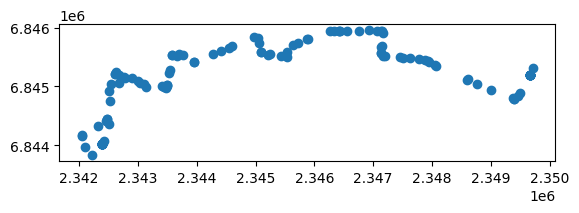

In [ ]:
gps_data_processed[gps_data_processed["id"] == "102|1411|585"].plot()

<Axes: >

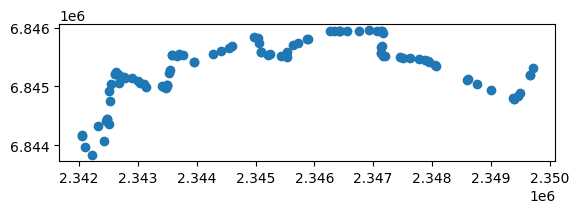

In [46]:
gps_data_no_stops[gps_data_no_stops["id"] == "102|1411|585"].plot()

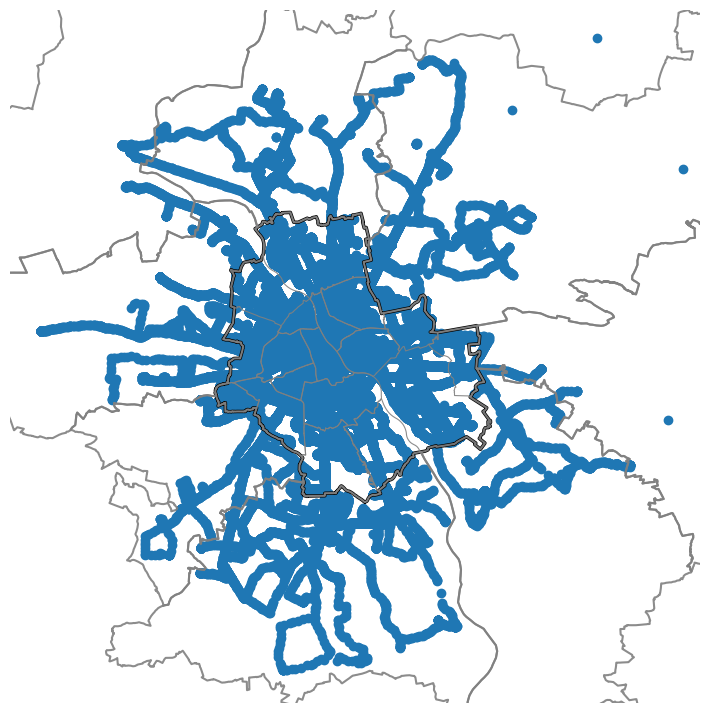

In [8]:
save_maps_to_file = False

filter_gminy = ["powiat " + item for item in [
    "wołomiński",
    "pruszkowski",
    "miński",
    "otwocki",
    "piaseczyński",
    "warszawski zachodni",
    "nowodworski",
    "legionowski",
    ]]

warsaw = ox.geocode_to_gdf("Warsaw, Poland")
districts = ox.features_from_place(
    "Warsaw, Poland",
    {"boundary": "administrative", "admin_level": "9"}
)
gminy = ox.features_from_place(
    "Masovian Voivodeship, Poland",
    {"admin_level": "6"}
)

districts = districts[districts["admin_level"] == "9"]
districts = districts[districts.geom_type == "Polygon"]
districts = districts[districts["boundary"].notnull()]
districts = districts[districts["wikidata"].notnull()]

gminy = gminy[gminy["boundary"] == "administrative"]
gminy = gminy[gminy["admin_level"] == "6"]
gminy = gminy[gminy.geom_type == "Polygon"]
gminy = gminy[gminy["name"].isin(filter_gminy)]
gminy = gminy.drop_duplicates()

warsaw = warsaw.to_crs(epsg=3857)
districts = districts.to_crs(epsg=3857)
gminy = gminy.to_crs(epsg=3857)

if save_maps_to_file:
    warsaw.to_file(f"{data_parent_directory_maps}/warsaw_outline.shp")
    districts.to_file(f"{data_parent_directory_maps}/warsaw_districts.shp")
    gminy.to_file(f"{data_parent_directory_maps}/gminy.shp")


fig, ax = plt.subplots(figsize=(9, 9))
warsaw.boundary.plot(ax=ax, linewidth=2.5, color="black")
districts.boundary.plot(ax=ax, linewidth=0.8, color="gray", alpha=0.9)
gminy.boundary.plot(ax=ax, linewidth=1.5, color="gray", alpha=0.9)
gps_data_processed.plot(ax=ax)

magnify_factor_y = 0.005
magnify_factor_x = 0.015
minx, miny, maxx, maxy = warsaw.total_bounds
minx *= (1-magnify_factor_x)
miny *= (1-magnify_factor_y)
maxx *= (1+magnify_factor_x)
maxy *= (1+magnify_factor_y)

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_aspect("equal")
ax.set_axis_off()

plt.show()